<a href="https://colab.research.google.com/github/adeepH/DravidianOffensive/blob/main/CM/Tamil/XLM_R_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 26.7MB/s 
     |████████████████████████████████| 1.2MB 53.0MB/s 
     |████████████████████████████████| 901kB 32.6MB/s 
     |████████████████████████████████| 3.0MB 46.7MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('/content/tamil_offensive_full_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,movie vara level la Erika poguthu,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,5
2,Padam nalla comedy padama irukum polaye..,0
3,karthick subburaj anne .... intha padam vetri ...,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,0
...,...,...
35134,Trending number #2 idhukku nammalam karanamnu ...,0
35135,"Movie script super, athuvum HIP HOP Tamizha mu...",0
35136,Just 3k likes for 300k likes,0
35137,Aaloo le lo. Kanda le lo.,5


In [3]:
val = pd.read_csv('/content/tamil_offensive_full_test_with_labels.csv', delimiter='\t', names=['tweets','label','nan'])
val = val.drop(columns=['nan'])
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

,tweets,labels
0,14.12.2018 epo trailer pathutu irken ... Semay...,0
1,Paka thana poro movie la Enna irukunu,0
2,“U kena tunggu lebih lama lagi untuk tahu saya...,5
3,Suriya anna vera level anna mass,0
4,suma kaththaatha da sound over a pooda kudaath...,4
...,...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,1
4388,Babu mele ko ye song sunke kuch yesa feel hua ...,5
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,0
4390,Vijay's all movies look like same.,0


In [4]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [5]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (35139, 2)
validation set size: (4392, 2)


In [6]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([ 0.23034415,  2.29037935,  2.4995732 , 12.89977974,  2.01531315,
        4.0278542 ])

In [7]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [9]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [10]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('xlm-roberta-base')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [13]:
model = RFClassifier(6)
model = model.to(device)

In [14]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-cased.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01 | Epoch Time: 15m 33s
Train Loss 0.9900837708349332 accuracy 0.7293320811633798
Val Loss 0.8365838994150576 accuracy 0.7447632058287796

Epoch: 02 | Epoch Time: 15m 36s
Train Loss 0.7953016864266366 accuracy 0.7470047525541421
Val Loss 0.7782620388096657 accuracy 0.7552367941712204

Epoch: 03 | Epoch Time: 15m 35s
Train Loss 0.7393877899326771 accuracy 0.7541478129713424
Val Loss 0.7375967421609423 accuracy 0.7563752276867031

Epoch: 04 | Epoch Time: 15m 35s
Train Loss 0.7091725398536375 accuracy 0.760522496371553
Val Loss 0.7414305931416111 accuracy 0.7581967213114754

Epoch: 05 | Epoch Time: 15m 35s
Train Loss 0.6867683944211861 accuracy 0.7654173425538575
Val Loss 0.7281166904646418 accuracy 0.7563752276867031



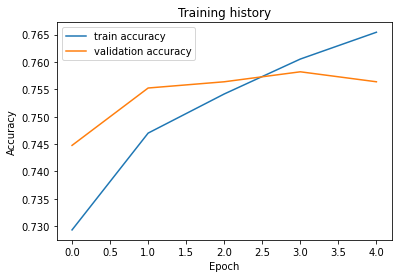

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [20]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.7563752276867031

In [21]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [22]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
class_name=['Not_offensive',
'not-Tamil',
'Offensive_Targeted_Insult_Individual',
'Offensive_Targeted_Insult_Group',          
'Offensive_Untargetede',                    
'Offensive_Targeted_Insult_Other']

In [24]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0, digits=4))

                                      precision    recall  f1-score   support

                       Not_offensive     0.8058    0.9586    0.8756      3190
                           not-Tamil     0.2985    0.1389    0.1896       288
Offensive_Targeted_Insult_Individual     0.0000    0.0000    0.0000       315
     Offensive_Targeted_Insult_Group     0.0000    0.0000    0.0000        71
               Offensive_Untargetede     0.3464    0.3125    0.3286       368
     Offensive_Targeted_Insult_Other     0.8321    0.6813    0.7491       160

                            accuracy                         0.7564      4392
                           macro avg     0.3805    0.3485    0.3571      4392
                        weighted avg     0.6642    0.7564    0.7032      4392



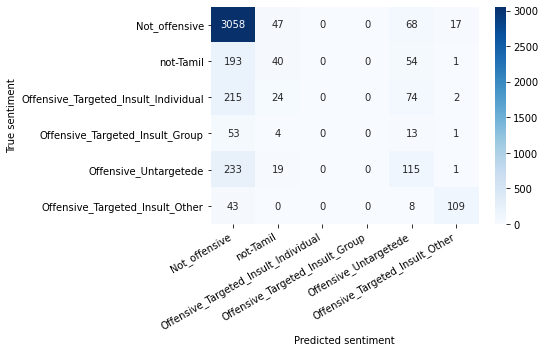

In [25]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)